# Aufgabe 1: Reinforcement Learning mit Policy Network

![CartPole](https://www.gymlibrary.dev/_images/cart_pole.gif)

[CartPole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) ist ein Kontrollproblem, bei dem es darum geht, ein auf einem Wagen montiertes Pendel zu balancieren.

Es eignet sich als einfaches Einstiegsbeispiel für Reinforcement Learning, da der Zustandsraum mit vier Dimensionen 

- Position des Wagens,
- Geschwindigkeit des Wagens,
- Winkel des Pendels, und
- Winkelgeschwindigkeit des Pendels

sehr klein und die Anzahl der Aktionen

- Wagen nach links schieben oder
- Wagen nach rechts schieben

überschaubar ist.

In der ersten Aufgabe geht es darum, das Pendel mit einem einfachen *Policy Network* auszubalancieren.

In [2]:
!pip install gym
!pip install pygame
!pip install moviepy
!pip install pysdl2
!pip install pyvirtualdisplay

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached pygame-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (21.9 MB)
  Using cached moviepy-1.0.3-py3-none-any.whl
  Using cached imageio_ffmpeg-0.4.7-py3-none-manylinux2010_x86_64.whl (26.9 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
  Using cached PySDL2-0.9.14-py3-none-any.whl
  Using cached PyVirtualDisplay-3.0-py3-none-any.whl (15 kB)


Zunächst erzeugen wir ein *Environment*.

In [1]:
import gym
import random 
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical

from gym import wrappers
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm




## Rendering im Jupyter Notebook

Normalerweise benötigt man für das Rendern eine "richtige" Anwendung. Wir behelfen uns hier mit `matplotlib`.

In [6]:
def render(env, img):
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Baseline: `RandomPolicy`

Die folgende Policy macht einfach zufällige Aktionen.

In [7]:
class RandomPolicy:
    
    def __call__(self, observation):
        return random.choice([0, 1])
    
    def update(self, *args):
        # Do nothing
        pass
    
    def init_game(self, observation):
        pass
    

In [2]:
def play_game(policy, episodes=2000, do_render = False, seed=100):
    random.seed(seed)
    torch.manual_seed(seed)
    if do_render:
        env = gym.make("CartPole-v1", render_mode="rgb_array")
    else:
        env = gym.make("CartPole-v1")
    observation, info = env.reset(seed=seed)
    policy.init_game(observation)

    if do_render:
        plt.ion()
        plt.axis('off')
        img = plt.imshow(env.render())
   
    status = {}
    episode = 0
    status['steps'] = 0
    status['episode_reward'] = 0
    status['average_reward'] = 0
    total_reward = 0
    

    with tqdm(total=episodes) as pbar:
        pbar.set_postfix(status)
        while True:
            try:
                action = policy(observation)
                observation, reward, terminated, truncated, info = env.step(action)
                status['steps'] += 1
                status['episode_reward'] += reward
                if do_render:
                    render(env, img)
                policy.update(observation, reward, terminated, truncated, info, pbar)

                if terminated or status['steps'] > 1000:
                    episode += 1
                    if episode > pbar.total:
                        break
                    total_reward += status['episode_reward']
                    status['average_reward'] = 0.05 * status['episode_reward'] + (1 - 0.05) * status['average_reward']
                    if status['average_reward'] > env.spec.reward_threshold:
                        print(f"Solved! Running reward is now {status['average_reward']} and "
                              f"the last episode runs to {status['steps']} time steps!")
                        break

                    pbar.set_postfix(status, refresh=episode % 10 == 0)
                    pbar.update()
                    status['steps'] = 0
                    
                    status['episode_reward'] = 0
                    observation, info = env.reset()
                    policy.init_game(observation)

            except KeyboardInterrupt:
                break
    env.close()

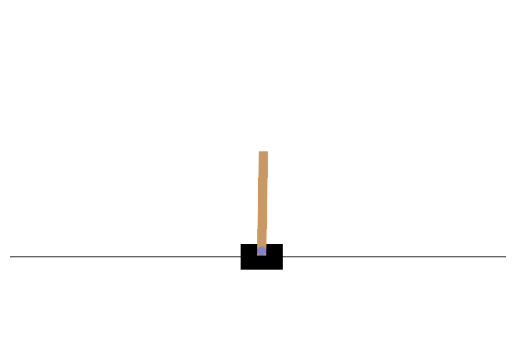

In [29]:
policy = RandomPolicy()
play_game(policy, episodes=10, do_render=True)

In [24]:
class PolicyNetwork(nn.Module):

    def __init__(self, hidden_size=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, hidden_size),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(hidden_size, 2),
            nn.Softmax(dim=-1)
        )
        
        
    def forward(self, x):
        x = self.fc(x)
        x = self.policy(x)
        return x

In [25]:
from collections import namedtuple
SavedAction = namedtuple('SavedAction', ['log_prob'])
    
class SimplePolicy:
    
    def __init__(self, gamma=0.99, lr=5e-3):
        # Two possible actions 0, 1
        self.ACTIONS = [0, 1]       
        self.net = PolicyNetwork()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.mean_reward = None
        self.games = 0
        self.gamma = gamma
        self.eps = np.finfo(np.float32).eps.item()
        
    def __call__(self, observation):
 
        probs = self.net(torch.tensor(observation))
        m = Categorical(probs)
        action = m.sample()
        
        self.memory.append(SavedAction(m.log_prob(action)))
        
        return self.ACTIONS[action.item()]
        
    def init_game(self, observation):
        self.memory = []
        self.rewards = []
        self.total_reward = 0
        
        
    def discount_rewards(self, r):
        discounted = torch.zeros(len(r))
        summe = 0
        for t in reversed(range(0, len(r))):
            summe = summe * self.gamma + r[t]
            discounted[t] = summe
        return discounted
        
    def update(self, observation, reward, terminated, truncated, info, status):
        self.total_reward += reward
        self.rewards.append(reward)
        if terminated:
            self.games += 1
            if self.mean_reward is None:
                self.mean_reward = self.total_reward
            else:
                self.mean_reward = self.mean_reward * 0.95 + self.total_reward * (1.0 - 0.95)
            
            self.optimizer.zero_grad()
                
            # calculate discounted reward and make it normal distributed
            discounted = []
            R = 0
            for r in self.rewards[::-1]:
                R = r + self.gamma * R
                discounted.insert(0, R)
            discounted = torch.tensor(discounted)
            discounted = (discounted - discounted.mean()) / (discounted.std() + self.eps)
            
            policy_losses = []
            for mem, discounted_reward in zip(self.memory, discounted):
                policy_losses.append(-(mem.log_prob * discounted_reward))
                
            loss = torch.stack(policy_losses).sum()
            loss.backward()    
            self.optimizer.step()
            
            if self.games % 1000 == 0:
                self.save(f"model_{self.games}.pt")
    
    
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.games = checkpoint['games']
        self.mean_reward = checkpoint['mean_reward']
        
    def save(self, PATH):
        torch.save({
                    'games': self.games,
                    'model_state_dict': self.net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'mean_reward': self.mean_reward}, PATH)

In [26]:
policy = SimplePolicy()
play_game(policy)

  0%|          | 0/2000 [00:00<?, ?it/s]

Solved! Running reward is now 501.065650159469 and the last episode runs to 1001 time steps!


In [3]:
class ActorCriticNetwork(nn.Module):

    def __init__(self, hidden_size=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, hidden_size),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(hidden_size, 2),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(hidden_size, 1)
        )
        
        
    def forward(self, x):
        x = self.fc(x)
        p = self.policy(x)
        v = self.critic(x)
        return p, v

In [4]:
from collections import namedtuple
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
    
class ACPolicy:
    
    def __init__(self, gamma=0.99, lr=5e-3):
        # Two possible actions 0, 1
        self.ACTIONS = [0, 1]       
        self.net = ActorCriticNetwork()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.mean_reward = None
        self.games = 0
        self.gamma = gamma
        self.eps = np.finfo(np.float32).eps.item()

        
    def __call__(self, observation):
 
        probs, value = self.net(torch.tensor(observation))
        m = Categorical(probs)
        action = m.sample()
        
        self.memory.append(SavedAction(m.log_prob(action), value))
        self.last_observation = observation
        
        return self.ACTIONS[action.item()]
        
    def init_game(self, observation):
        self.memory = []
        self.rewards = []
        self.total_reward = 0
        
        
    def update(self, observation, reward, terminated, truncated, info, status):
        self.total_reward += reward
        self.rewards.append(reward)
        if terminated:
            self.games += 1
            if self.mean_reward is None:
                self.mean_reward = self.total_reward
            else:
                self.mean_reward = self.mean_reward * 0.95 + self.total_reward * (1.0 - 0.95)
                
            # calculate discounted reward and make it normal distributed
            discounted = []
            R = 0
            for r in self.rewards[::-1]:
                R = r + self.gamma * R
                discounted.insert(0, R)
            discounted = torch.tensor(discounted)
            #discounted = (discounted - discounted.mean()) / (discounted.std() + self.eps)
            
            policy_losses = []
            value_losses = []
            for mem, discounted_reward in zip(self.memory, discounted):
                advantage = discounted_reward - mem.value.item() 
                policy_losses.append(-(mem.log_prob * advantage))
                
                value_losses.append(F.smooth_l1_loss(mem.value, discounted_reward.unsqueeze(0)))
               
            self.optimizer.zero_grad()
            loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
            loss.backward()    
            self.optimizer.step()
            
            if self.games % 1000 == 0:
                self.save(f"model_{self.games}.pt")
    
    
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.games = checkpoint['games']
        self.mean_reward = checkpoint['mean_reward']
        
    def save(self, PATH):
        torch.save({
                    'games': self.games,
                    'model_state_dict': self.net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'mean_reward': self.mean_reward}, PATH)

In [5]:
policy = ACPolicy()
play_game(policy)

  0%|          | 0/2000 [00:00<?, ?it/s]

Solved! Running reward is now 477.5831251868573 and the last episode runs to 608 time steps!


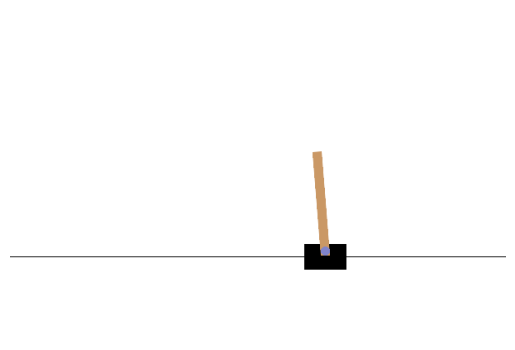

In [ ]:
play_game(policy, do_render = True)